
ผลการวิเคราะห์สต็อก:
                 product  current_stock  avg_monthly_sales  stock_coverage_months  safety_stock  reorder_point  predicted_sales_3m  excess_stock  excess_stock_value
0           ปากกาลูกลื่น           1982              757.0                   2.62           NaN            NaN              2271.0             0                 0.0
1  003 / เครื่องฟอกอากาศ             80               12.0                   6.67           NaN            NaN                36.0             0                 0.0

คำแนะนำ:
                 product          status risk_level                                                   action excess_stock_value
0           ปากกาลูกลื่น            ปกติ        ต่ำ                              ติดตามยอดขายและสต็อกตามปกติ           0.00 บาท
1  003 / เครื่องฟอกอากาศ  สต็อกสูงเกินไป        สูง  ควรระงับการสั่งซื้อและพิจารณาทำโปรโมชั่นเพื่อระบายสต็อก           0.00 บาท


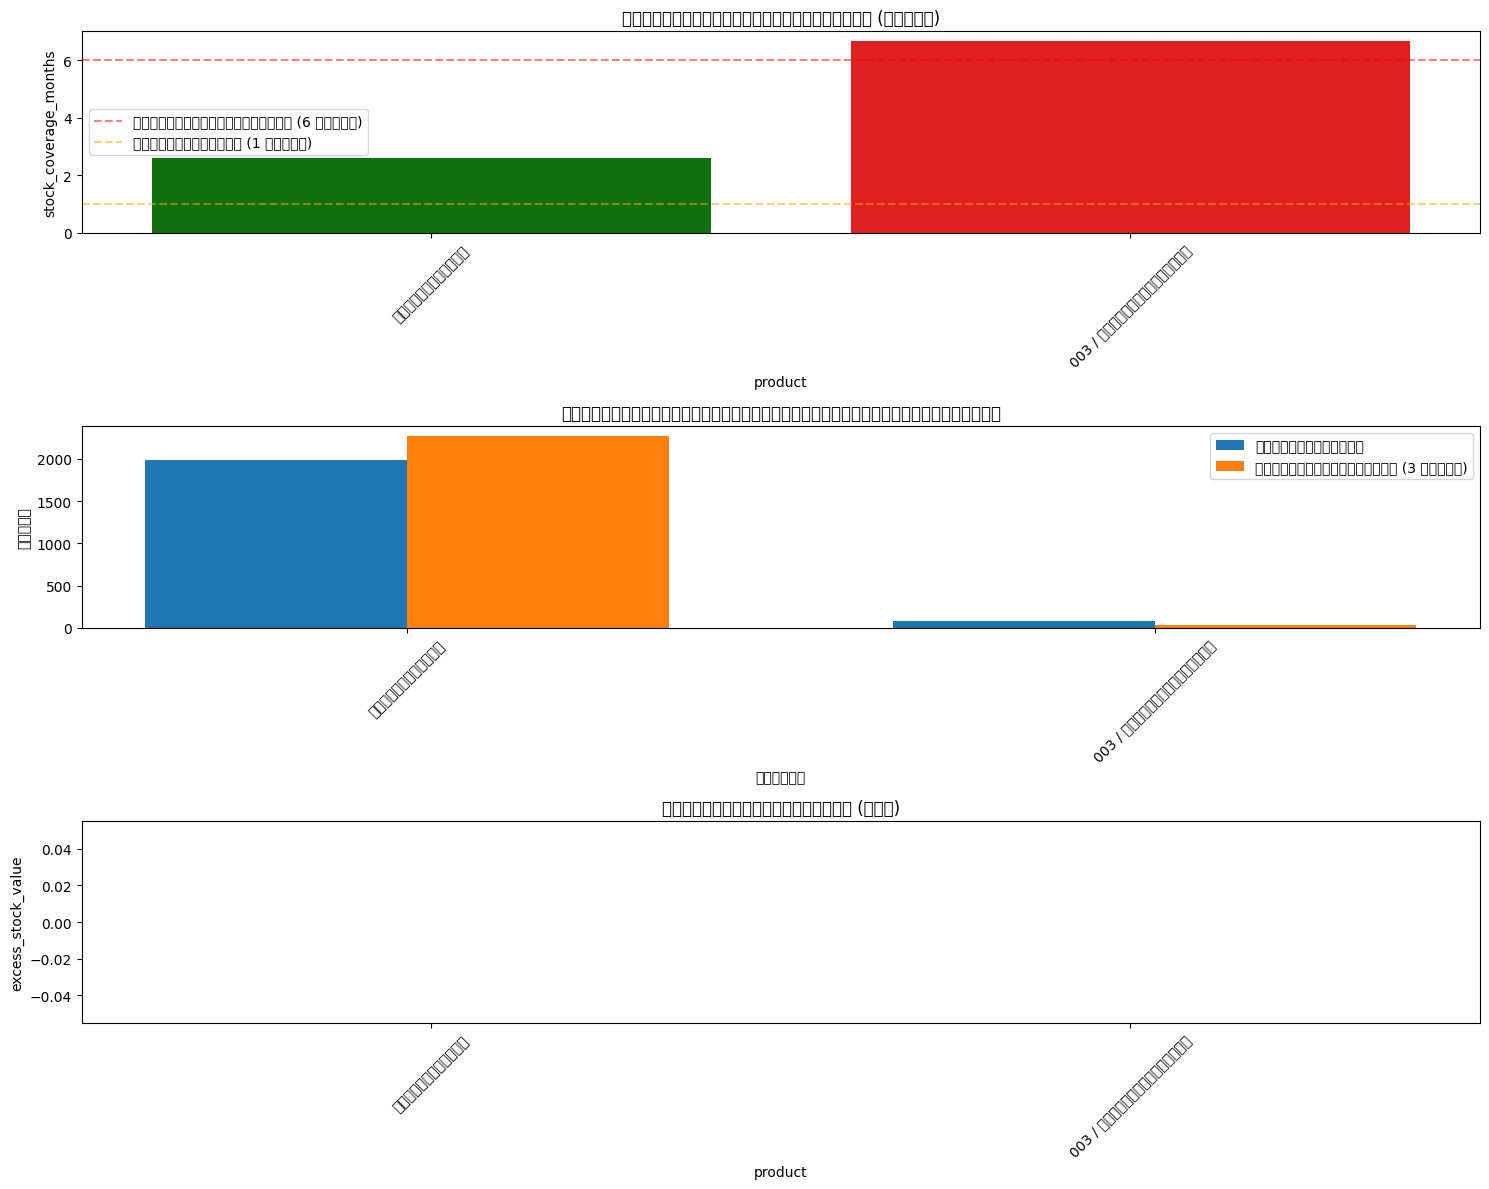

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class InventoryOptimizer:
    def __init__(self):
        self.inventory_df = None
        self.sales_df = None
        self.monthly_sales = None
        
    def load_data(self, inventory_path, sales_path):
        """
        โหลดข้อมูลจากไฟล์ CSV
        """
        self.inventory_df = pd.read_csv(inventory_path)
        self.sales_df = pd.read_csv(sales_path)
        
        # แปลง format วันที่
        self.sales_df['documentDate'] = pd.to_datetime(self.sales_df['documentDate'])
        
    def preprocess_data(self):
        """
        เตรียมข้อมูลสำหรับการวิเคราะห์
        """
        # จัดกลุ่มข้อมูลการขายรายเดือน
        self.monthly_sales = (self.sales_df.groupby([
            pd.Grouper(key='documentDate', freq='M'),
            'product'
        ])['productQuantity']
        .sum()
        .reset_index())
        
    def calculate_metrics(self):
        """
        คำนวณ metrics สำหรับการวิเคราะห์สต็อก
        """
        results = []
        
        for product in self.inventory_df['รายการสินค้า'].unique():
            # ข้อมูลสต็อกปัจจุบัน
            current_stock = self.inventory_df[
                self.inventory_df['รายการสินค้า'] == product
            ]['จำนวน'].values[0]
            
            # ข้อมูลการขายของสินค้า
            product_sales = self.monthly_sales[
                self.monthly_sales['product'] == product
            ].sort_values('documentDate')
            
            if len(product_sales) > 0:
                # คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของยอดขายรายเดือน
                avg_monthly_sales = product_sales['productQuantity'].mean()
                std_monthly_sales = product_sales['productQuantity'].std()
                
                # คำนวณ Stock Coverage (จำนวนเดือนที่สต็อกจะอยู่ได้)
                stock_coverage = current_stock / avg_monthly_sales if avg_monthly_sales > 0 else float('inf')
                
                # คำนวณ Safety Stock โดยใช้ Service Level 95% (Z=1.96)
                lead_time_months = 3  # สมมติ lead time 3 เดือน
                safety_stock = 1.96 * std_monthly_sales * np.sqrt(lead_time_months)
                
                # คำนวณ Reorder Point
                reorder_point = (avg_monthly_sales * lead_time_months) + safety_stock
                
                # ทำนายยอดขาย 3 เดือนข้างหน้า
                if len(product_sales) >= 4:
                    try:
                        model = ExponentialSmoothing(
                            product_sales['productQuantity'],
                            seasonal_periods=3,
                            trend='add',
                            seasonal='add',
                            initialization_method="estimated"
                        ).fit()
                        forecast = model.forecast(3)
                        predicted_sales_3m = forecast.sum()
                    except:
                        # ถ้าโมเดลไม่สามารถทำนายได้ ใช้ค่าเฉลี่ยแทน
                        predicted_sales_3m = avg_monthly_sales * 3
                else:
                    predicted_sales_3m = avg_monthly_sales * 3
                
                # คำนวณ Excess Stock
                excess_stock = max(0, current_stock - (predicted_sales_3m + safety_stock))
                
                # คำนวณมูลค่าต่อหน่วย
                unit_value = float(self.inventory_df[
                    self.inventory_df['รายการสินค้า'] == product
                ]['มูลค่าต่อหน่วย'].values[0])
                
                results.append({
                    'product': product,
                    'current_stock': current_stock,
                    'avg_monthly_sales': round(avg_monthly_sales, 2),
                    'stock_coverage_months': round(stock_coverage, 2),
                    'safety_stock': round(safety_stock, 2),
                    'reorder_point': round(reorder_point, 2),
                    'predicted_sales_3m': round(predicted_sales_3m, 2),
                    'excess_stock': round(excess_stock, 2),
                    'excess_stock_value': round(excess_stock * unit_value, 2)
                })
        
        return pd.DataFrame(results)
    
    def get_recommendations(self, results_df):
        """
        สร้างคำแนะนำสำหรับการจัดการสต็อก
        """
        recommendations = []
        
        for _, row in results_df.iterrows():
            status = ""
            action = ""
            risk_level = ""
            
            if row['stock_coverage_months'] > 6:
                status = "สต็อกสูงเกินไป"
                action = "ควรระงับการสั่งซื้อและพิจารณาทำโปรโมชั่นเพื่อระบายสต็อก"
                risk_level = "สูง"
            elif row['stock_coverage_months'] < 1:
                status = "สต็อกต่ำ"
                action = f"ควรสั่งซื้อเพิ่มอย่างน้อย {int(row['reorder_point'])} ชิ้น"
                risk_level = "สูง"
            elif row['current_stock'] < row['reorder_point']:
                status = "ถึงจุดสั่งซื้อ"
                action = f"ควรสั่งซื้อเพิ่มให้ถึงระดับ {int(row['reorder_point'] + row['safety_stock'])} ชิ้น"
                risk_level = "ปานกลาง"
            else:
                status = "ปกติ"
                action = "ติดตามยอดขายและสต็อกตามปกติ"
                risk_level = "ต่ำ"
            
            recommendations.append({
                'product': row['product'],
                'status': status,
                'risk_level': risk_level,
                'action': action,
                'excess_stock_value': f"{row['excess_stock_value']:,.2f} บาท"
            })
        
        return pd.DataFrame(recommendations)
    
    def plot_stock_analysis(self, results_df):
        """
        สร้างกราฟวิเคราะห์สต็อก
        """
        plt.figure(figsize=(15, 12))
        
        # Plot 1: Stock Coverage
        plt.subplot(3, 1, 1)
        colors = ['red' if x > 6 else 'orange' if x < 1 else 'green' for x in results_df['stock_coverage_months']]
        sns.barplot(data=results_df, x='product', y='stock_coverage_months', palette=colors)
        plt.axhline(y=6, color='r', linestyle='--', alpha=0.5, label='เกณฑ์สต็อกสูงเกินไป (6 เดือน)')
        plt.axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='เกณฑ์สต็อกต่ำ (1 เดือน)')
        plt.title('ระยะเวลาที่สต็อกจะอยู่ได้ (เดือน)')
        plt.xticks(rotation=45)
        plt.legend()
        
        # Plot 2: Current Stock vs Predicted Sales
        plt.subplot(3, 1, 2)
        width = 0.35
        x = np.arange(len(results_df))
        
        plt.bar(x - width/2, results_df['current_stock'], width, label='สต็อกปัจจุบัน')
        plt.bar(x + width/2, results_df['predicted_sales_3m'], width, label='ยอดขายที่คาดการณ์ (3 เดือน)')
        
        plt.xlabel('สินค้า')
        plt.ylabel('จำนวน')
        plt.title('เปรียบเทียบสต็อกปัจจุบันกับยอดขายที่คาดการณ์')
        plt.xticks(x, results_df['product'], rotation=45)
        plt.legend()
        
        # Plot 3: Excess Stock Value
        plt.subplot(3, 1, 3)
        sns.barplot(data=results_df, x='product', y='excess_stock_value')
        plt.title('มูลค่าสต็อกส่วนเกิน (บาท)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        return plt

# ตัวอย่างการใช้งาน
if __name__ == "__main__":
    optimizer = InventoryOptimizer()
    
    try:
        # โหลดและวิเคราะห์ข้อมูล
        optimizer.load_data('data/inventory.csv', 'data/sales.csv')
        optimizer.preprocess_data()
        
        # วิเคราะห์สต็อก
        results = optimizer.calculate_metrics()
        
        # สร้างคำแนะนำ
        recommendations = optimizer.get_recommendations(results)
        
        # แสดงผลลัพธ์
        print("\nผลการวิเคราะห์สต็อก:")
        print(results.to_string())
        
        print("\nคำแนะนำ:")
        print(recommendations.to_string())
        
        # สร้างกราฟ
        plt = optimizer.plot_stock_analysis(results)
        plt.show()
        
    except Exception as e:
        print(f"เกิดข้อผิดพลาด: {str(e)}")